In [97]:
import sys
sys.path.append('../..')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
import plotly.graph_objects as go
import numpy as np
import pandas_ta as ta
from Tools.plotting import CandlePlot
from Tools.backtest_tools import get_n_columns

In [98]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../../DB/15m/INJUSDT_15m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [99]:
class CobraStrategy:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
            fast_length = 40,
            slow_length = 200,
            std_dev_length = 1000) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.fast_length = fast_length
        self.slow_length = slow_length
        self.std_dev_length = std_dev_length
        self.trades = pd.DataFrame()
        

    def smoothed(self, series, period=5):
        return series.rolling(window=period).mean()

    def populate_indicators(self):
        df = self.df
        df.drop(columns=df.columns.difference(['open', 'high', 'low', 'close', 'volume']), inplace=True)

        # Populate indicators
        df['slow'] = ta.ema(df['close'], self.slow_length)
        df['fast'] = ta.ema(df['close'], self.fast_length)


        # Bollinger Bands calculation
        dev = df['close'].rolling(self.std_dev_length).std()
        mult = 0.5
        df['upper_band'] = df['fast'] + (dev * mult)
        df['lower_band'] = df['fast'] - (dev * mult)

        df = get_n_columns(df, ['fast', 'slow'], 1)

        df['slow_slope'] = df['slow'].diff()
        slope_threshold = 0.001  # Adjust as needed
        df['is_horizontal'] = abs(df['slow_slope']) < slope_threshold


        # Create conditions
        df['c_bullish'] = (df['slow'] < df['fast']) & (df['n1_slow'] < df['n1_fast'])
        df['c_bearish'] = (df['slow'] > df['fast']) & (df['n1_slow'] > df['n1_fast'])
        df['bullish'] = (df['slow'] < df['fast']) 
        df['bearish'] = (df['slow'] > df['fast']) 

        df['buy_condition'] = (~df['is_horizontal']) & (df['bullish']) & (df['close'] < df['fast']) & (df['close'].shift(1) > df['fast'].shift(1))
        df['sell_condition'] = (~df['is_horizontal']) & (df['bearish']) & (df['close'] > df['fast']) & (df['close'].shift(1) < df['fast'].shift(1))



        df['close_buy_condition'] = ((df['close'] < df['upper_band']) & (df['close'].shift(1) > df['upper_band'].shift(1))) | df['c_bearish']
        df['close_sell_condition'] = ((df['close'] > df['lower_band']) & (df['close'].shift(1) < df['lower_band'].shift(1))) | df['c_bullish']

        self.df = df    
        return self.df

    def populate_buy_sell(self):
        df = self.df.copy()
        df.reset_index(drop=False, inplace=True)

        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        df['position'] = 0
        df['signal'] = ""

        position = 0  # 0 = no position, 1 = long, -1 = short

        for i in range(1, len(df)):
            # Debugging: Print current index and conditions
            #print(f"Index: {i}, Buy: {df['buy_condition'].iloc[i]}, Sell: {df['sell_condition'].iloc[i]}, Close Long: {df['close_buy_condition'].iloc[i]}, Close Short: {df['close_sell_condition'].iloc[i]}")

            # Buy signal
            if position == 0 and df['buy_condition'].iloc[i]:
                df.at[df.index[i], 'signal'] = 'open_long_market'
                df.at[df.index[i], 'open_long_market'] = True
                position = 1  # Long position

            # Sell signal
            elif position == 0 and df['sell_condition'].iloc[i]:
                df.at[df.index[i], 'signal'] = 'open_short_market'
                df.at[df.index[i], 'open_short_market'] = True
                position = -1  # Short position

            # Close long position
            elif position == 1 and df['close_buy_condition'].iloc[i]:
                df.at[df.index[i], 'signal'] = 'close_long_market'
                df.at[df.index[i], 'close_long_market'] = True
                position = 0

            # Close short position
            elif position == -1 and df['close_sell_condition'].iloc[i]:
                df.at[df.index[i], 'signal'] = 'close_short_market'
                df.at[df.index[i], 'close_short_market'] = True
                position = 0

            df.at[df.index[i], 'position'] = position

        df.set_index('datetime', drop=True, inplace=True)
        self.df = df
        return self.df




    
    # Running the backtest 
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       
        
    def _pointpos(self, x):
        if x['open_long_market']==True:
            return x['low']-1e-3, 'green'
        elif x['open_short_market']==True:
            return x['high']+1e-3, 'red'
        elif x['close_long_market']==True:
            return x['high']+1e-3, '#90EE90'
        elif x['close_short_market']==True:
            return x['low']+1e-3, '#FF7F7F'
        else:
            return np.nan, np.nan
    def add_signals(self):
        df = self.df.copy()
        df[['signals', 'sig_color']] = df.apply(lambda row: pd.Series(self._pointpos(row)), axis=1)

        self.df = df

    
    def plot(self, win=3000):
        dfplt = self.df[win:win+500]
        cp = CandlePlot(dfplt)
        cp.add_traces(['upper_band', 'lower_band', 'slow', 'fast'])
        cp.add_points()
        cp.show_plot()

In [100]:
strat = CobraStrategy(df_t)
strat.populate_indicators()
strat.populate_buy_sell()
strat.add_signals()


In [101]:
pd.set_option('display.max_rows', 1000)


In [102]:

strat.plot(win=-21700)

In [103]:
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
#df_trades

Period: [2022-11-21 00:00:00] -> [2024-09-03 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 6699.64 $
Performance vs US dollar: 569.96 %
Sharpe Ratio: 1.67
Worst Drawdown T|D: -55.56% | -56.19%
Buy and hold performance: 996.42 %
Performance vs buy and hold: -38.9 %
Total trades on the period: 461
Global Win rate: 53.58 %
Average Profit: 0.55 %
Total fees paid 2350.44$

Best trades: +21.92 % the 2023-04-14 09:00:00 -> 2023-04-14 22:00:00
Worst trades: -13.67 % the 2023-03-28 06:00:00 -> 2023-03-28 20:15:00


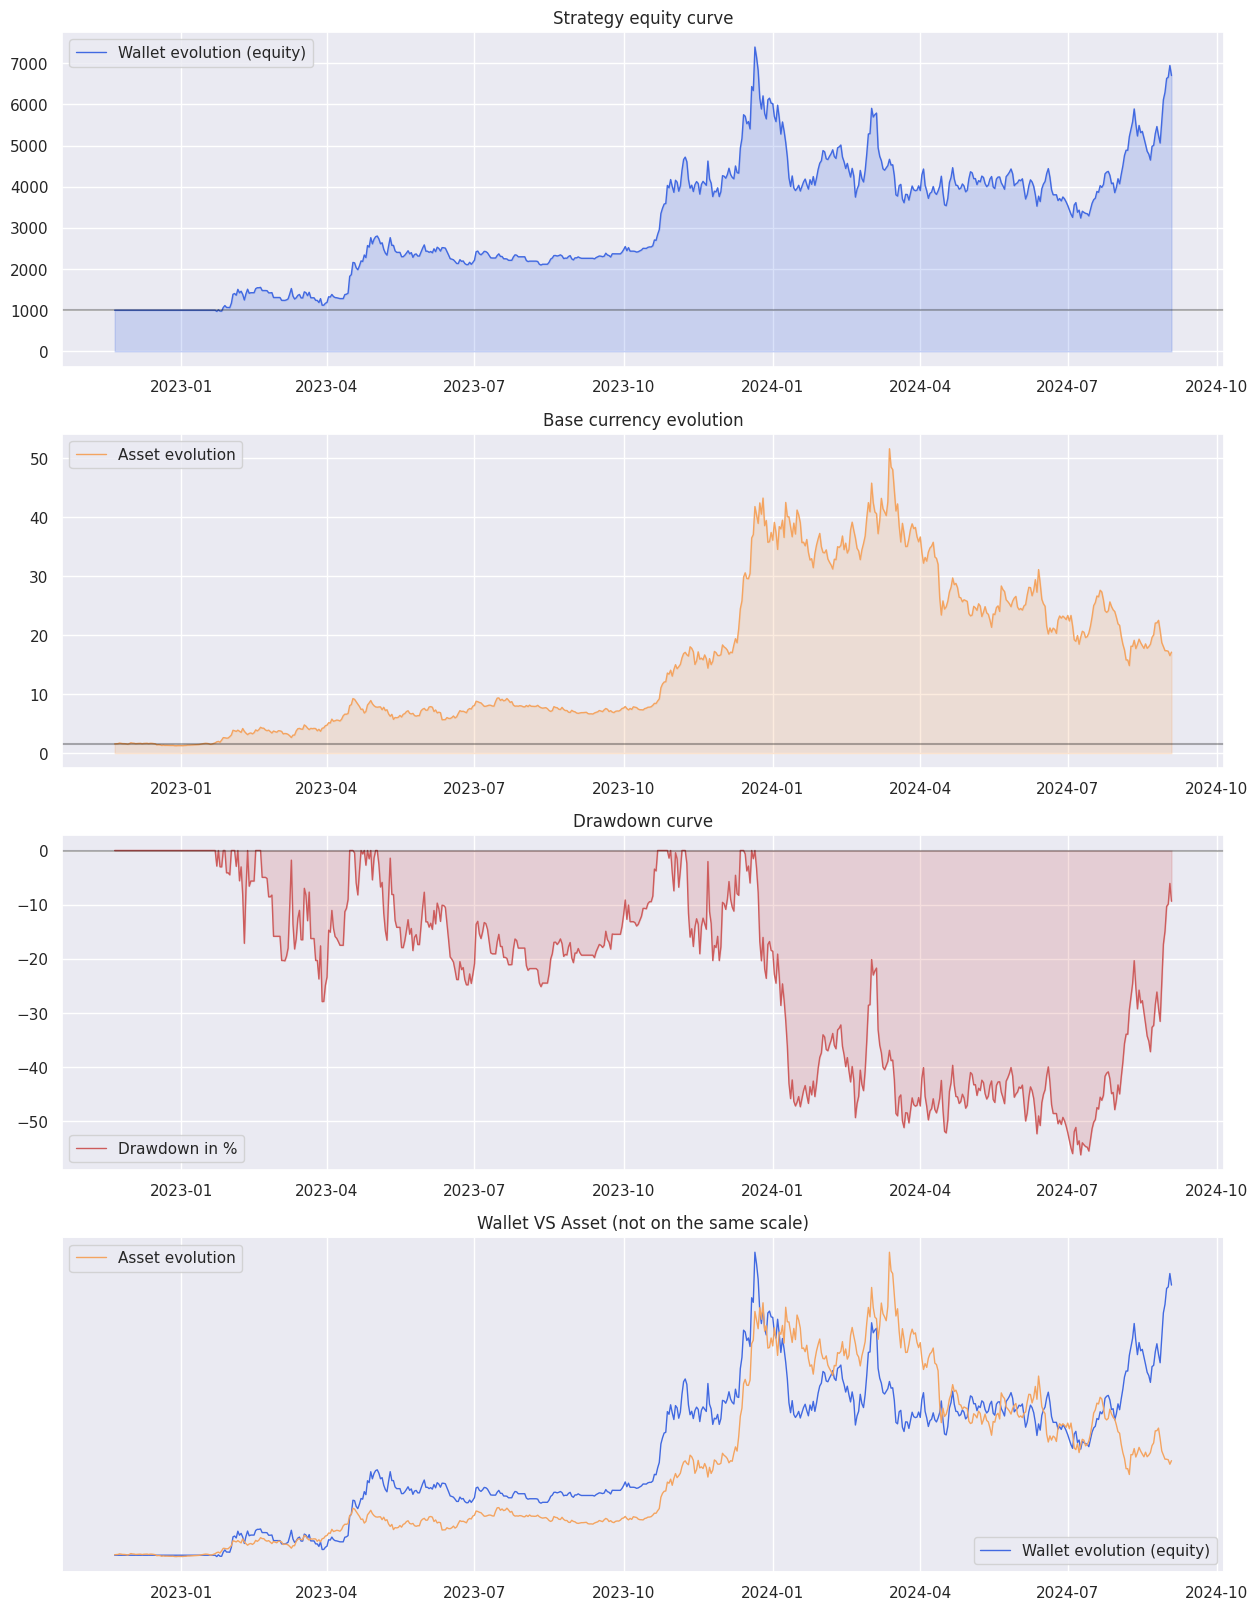

In [104]:
plot_wallet_vs_asset(df_days=df_days)

In [105]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=1,
    trades_to_forecast=1000,
    number_of_simulations=100,
    true_trades_to_show=10,
    show_all_simulations=True,
)

ValueError: Sample larger than population or is negative

----- 2022 Cumulative Performances: -0.75% -----


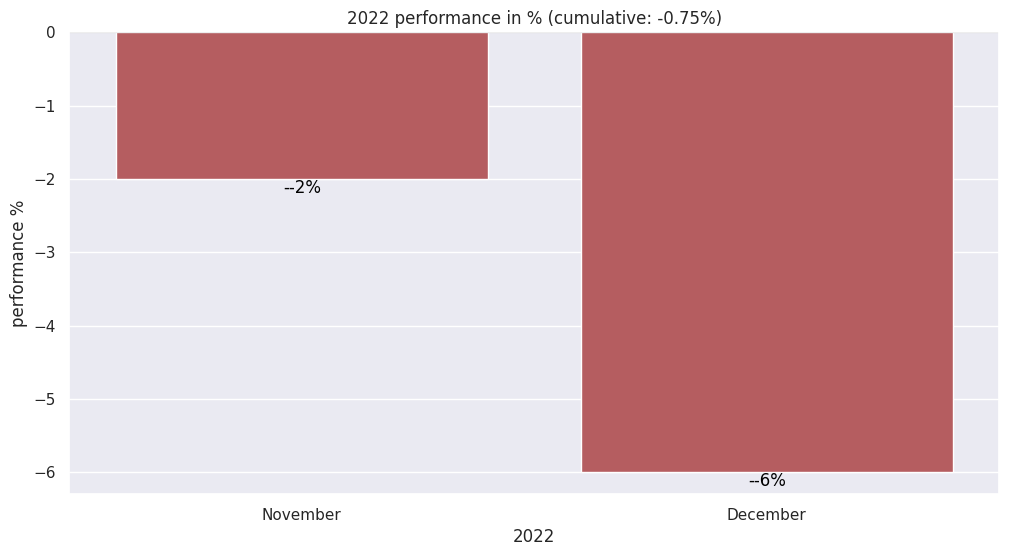

----- 2023 Cumulative Performances: 2.84% -----


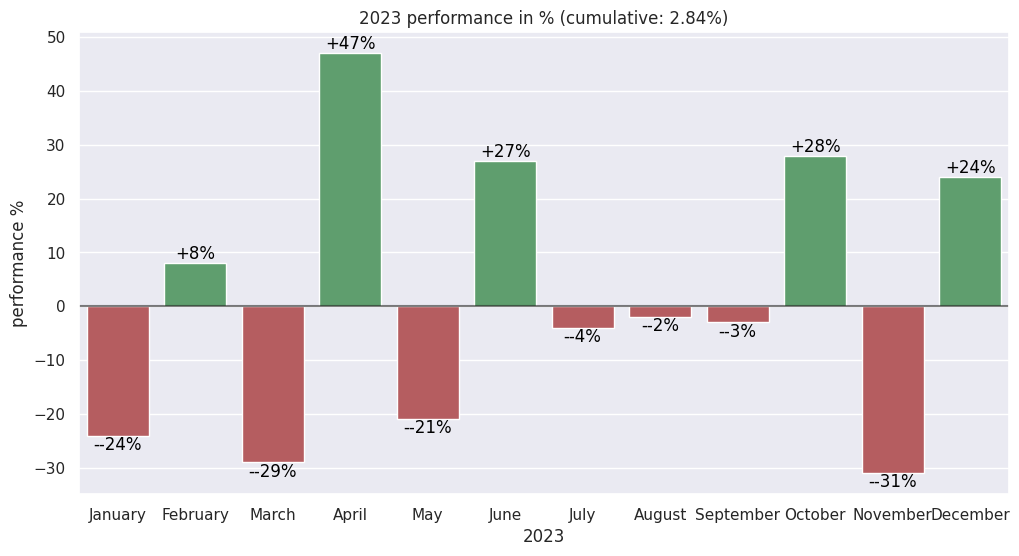

----- 2024 Cumulative Performances: -16.27% -----


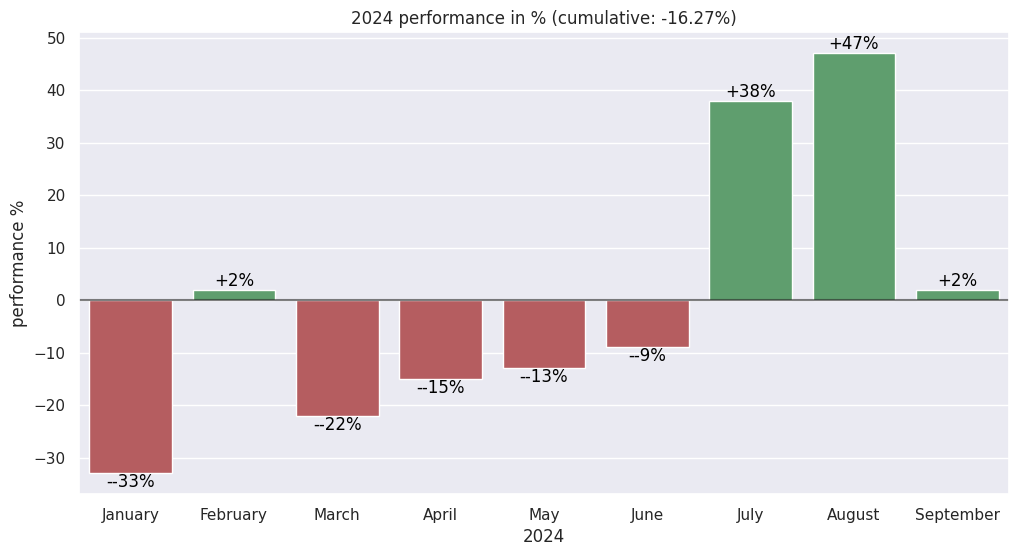

In [49]:
plot_bar_by_month(df_days=df_days)